In [55]:
import fastbook
fastbook.setup_book()

In [56]:
!pip install pathos

In [57]:
from fastbook import *
from glob import glob


<h4>FastAI Learner Module From Scratch</h4>

<h5>1) Data Gathering</h5>

In [58]:
path = untar_data(URLs.IMAGENETTE_160)
t = get_image_files(path)
Path.BASE_PATH = path

In [59]:
#phton implementation
fs = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
fs[0]

Path('train/n01440764/ILSVRC2012_val_00000293.JPEG')

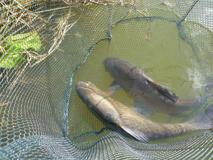

In [60]:
img = Image.open(fs[0])
img

<h5>Labels</h5>

In [61]:
lbls = fs.map(Self.parent.name())
lbls.unique()

(#10) ['n01440764','n02102040','n02979186','n03000684','n03028079','n03394916','n03417042','n03425413','n03445777','n03888257']

In [62]:
#reverse mapping [v2i -> value to index]
v2i = lbls.val2idx()
v2i

{'n01440764': 9855,
 'n02102040': 10250,
 'n02979186': 10607,
 'n03000684': 10993,
 'n03028079': 11402,
 'n03394916': 11796,
 'n03417042': 12185,
 'n03425413': 12604,
 'n03445777': 13003,
 'n03888257': 13393}

<h5>2) Dataset</h5>

In [63]:
class Dataset:
    def __init__(self, fns): self.fns = fns
    def __len__(self): return len(self.fns)

    def __getitem__(self, i):
        img = Image.open(self.fns[0]).resize((64, 64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(img).float()/255, tensor(y)


In [64]:
tf = L(o.parent.parent.name == 'train' for o in fs)
train, valid = fs[tf], fs[~tf]

In [65]:
train_ds,valid_ds = Dataset(train),Dataset(valid)
x,y = train_ds[1] # __getitem__ method that require index train_ds[i]

<Axes: title={'center': 'n01440764'}>

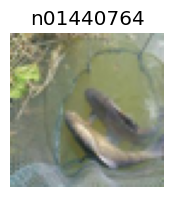

In [66]:
show_image(x, title=lbls[y])

<h5>Collate to a Mini-Batch</h5>

In [67]:
def collate(idxs, ds):
    xb, yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb), torch.stack(yb)

In [68]:
idxs = torch.linspace(1, 64, steps=64)
xb, yb = collate(idxs.long(), train_ds)
xb.shape, yb.shape

(torch.Size([64, 64, 64, 3]), torch.Size([64]))

<h5>DataLoader</h5>

In [69]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, nws=1):
        self.ds = ds
        self.bs = bs
        self.shuffle = shuffle
        self.nws = nws
    def __len__(self): return len(self.ds)//self.bs+1
    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.nws) as ex:
            #collating chunks of datasets into mini-batch 
            yield from ex.map(collate, chunks, ds=self.ds)


In [70]:

# error: multiprocessing doesn't work without running with if __name__ == '__main__'.
n_workers = min(16, defaults.cpus)
if __name__ == '__main__':
    nws = min(16, defaults.cpus)
    train_dl = DataLoader(train_ds, bs=64, shuffle=True, nws=n_workers)
    valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, nws=n_workers)
    xb, yb = first(train_dl)
    xbv, _ = first(valid_dl)
    print(xb.shape), print(yb.shape), print(len(train_dl))
    print(f'validation shape: {xbv.shape}')


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
torch.Size([64, 64, 64, 3])
torch.Size([64])
148
validation shape: torch.Size([256, 64, 64, 3])


<h5>Normalization [Image Statistics]</h5>

In [71]:
stats = [xb.mean((0,1,2)), xb.std((0,1,2))]
stats

[tensor([0.5192, 0.5411, 0.4518]), tensor([0.1097, 0.1070, 0.1075])]

In [72]:
((x-stats[0])/stats[1]).shape

torch.Size([64, 64, 3])

In [73]:
class Normilize:
    def __init__(self, stats): self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0])/self.stats[1]

In [74]:
norm = Normalize(stats)
def tfm_x(x): return norm(x).permute((0, 3, 1, 2))

In [75]:
t = tfm_x(xb)
t.mean((0,2,3)),t.std((0,2,3))

(tensor([0.5192, 0.5411, 0.4518]), tensor([0.1097, 0.1070, 0.1075]))

<h5>Module and Parameter</h5>

In [76]:
class Parameter(Tensor):
    """Custom Parameter Class Built from Pytorch Tensor Module"""
    def __new__(self, x): return Tensor._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs): self.requires_grad_()

<h6>Custom Tensor Class (Parameters)</h6>

In [77]:
Parameter(tensor(3.))

Parameter(3., requires_grad=True)

In [78]:
class Module:
    """Custom Module Built Here"""
    def __init__(self):
        self.hook = None
        self.params = []
        self.children = []
        self._training = False
    def register_parameters(self, *ps): self.params += ps
    def register_modules(self, *ms): self.children += ms

    @property
    def training(self): return self._training
    @training.setter # implement {set} as in C#
    def training(self, v): # v for value
        self._training = v
        for m in self.children: m.training = v
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])
    
    def __setattr__(self, k, v):
        super().__setattr__(k, v)
        if isinstance(v, Parameter):
            self.register_parameters(v)
        if isinstance(v,Module): self.register_modules(v)

    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None:
            self.hook(res, args)
        return res
    # binding cuda kernel to parameters
    def cuda(self):
        for p in self.parameters():
            p.data = p.data.cuda()

In [79]:
w = Parameter(torch.zeros(24,1,3,3))

In [80]:
nn.init.kaiming_normal_(w)

Parameter([[[[ 6.7944e-01, -7.5176e-01,  7.1088e-02],
             [ 3.9996e-01,  2.5160e-01,  2.5419e-01],
             [ 5.7263e-01,  1.2269e-01,  5.2557e-01]]],


           [[[ 4.5893e-01, -2.0277e-01, -2.7030e-01],
             [-3.7882e-01,  7.1278e-02,  6.4355e-01],
             [-9.8326e-01,  5.1115e-02, -5.1772e-01]]],


           [[[-6.1195e-01,  1.3291e-02, -3.1407e-01],
             [-8.1721e-02,  7.1390e-01, -7.4666e-01],
             [-5.1366e-01, -2.4827e-01, -3.2711e-01]]],


           [[[ 3.2304e-01,  1.8027e-01,  3.5592e-01],
             [ 3.7078e-01, -2.8552e-01, -4.1445e-02],
             [ 1.9279e-02, -1.0375e-01,  7.4371e-02]]],


           [[[-6.9513e-01,  4.3441e-01, -1.3431e-02],
             [-1.5928e-02,  4.5887e-01, -9.5919e-01],
             [-5.1350e-01,  2.3764e-01,  4.5445e-01]]],


           [[[-1.8251e-01,  5.4849e-01, -3.5271e-01],
             [ 5.2925e-01,  2.8007e-01,  4.7742e-01],
             [ 4.0518e-01,  1.9418e-01, -5.5810e-01]]],


    

<h5>Simple CNN</h5>

In [81]:
class ConvLayer(Module):
    def __init__(self,ni,nf,stride=1,bias=True,act=True):
        super().__init__()

        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None # same dimension as output
        self.stride = stride
        self.act = act
        #parameter initialization according to papers
        # act=True:  Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification
        # else: Understanding the difficulty of training deep feedforward neural networks
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)
    def forward(self, x):
        x = F.conv2d(x,self.w,self.b,stride=self.stride,padding=1)
        x = F.relu(x) if self.act else x
        return x

In [82]:
l = ConvLayer(3, 4)
len(l.parameters())
w = l.parameters()[0].shape
w

torch.Size([4, 3, 3, 3])

In [83]:
xbt = tfm_x(xb)
xbt.shape, w
conv = ConvLayer(3,4)
fout = conv(xbt)
fout.shape

torch.Size([64, 4, 64, 64])

<h5>Linear Layer</h5>

In [84]:
class Linear(Module):
    def __init__(self, ni, nf, bias=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf, ni))
        # same dimension as output
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.ni = ni
        self.nf = nf
        init = nn.init.xavier_normal_
        init(self.w)

    def forward(self, x): 
        return x@self.w.t() + self.b
        #efficient implementation using pytorch [F.linear(x, self.w, self.bias)]


<h5>Sequential Class Implementation</h5>

In [85]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

`register_modules` method we defined in `Module` should be called, since otherwise the contents of `layers` won't appear in `parameters`

<h5>AdaptivePool Implementation</h5>

In [86]:
class AdaptivePool(Module):
    def __init__(self):
        super().__init__()
    def forward(self,x): return x.mean((2,3)) # thats the dimension where the pixel values found


In [87]:
def simple_cnn():
    return Sequential(
        ConvLayer(3, 16, stride=2),  # 32
        ConvLayer(16, 32, stride=2),  # 16
        ConvLayer(32, 64, stride=2),  # 8
        ConvLayer(64, 64, stride=2),  # 4
        AdaptivePool(),
        Linear(64, 10)
    )

In [88]:
model = simple_cnn() #instance of sequential -> we can call layers
model.layers,len(model.parameters())


((<__main__.ConvLayer at 0x2336983fc70>,
  <__main__.Linear at 0x2336983f220>),
 10)

<h5>Testing Module Hook Binding</h5>

In [89]:
def print_stats(out, inp):
    print(out.mean().item(), out.std().item())
#hook binding at conv layers only
for i in range(4): model.layers[i].hook = print_stats
#testing for hooks
model.layers[0].hook

<function __main__.print_stats(out, inp)>

In [90]:
r = model(xbt)
r

0.4193919599056244 0.40364789962768555
0.28814375400543213 0.47149649262428284
0.19523757696151733 0.3061261475086212
0.15440668165683746 0.2534728944301605


Parameter([[-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101,  0.0338, -0.1930, -0.6992],
           [-0.2144,  0.4471, -0.0782,  0.0625, -0.1240,  0.0703, -0.5101

<h5>Loss Construction</h5>

<h6>1) Negative-Log Likelyhood</h6>

In [91]:
#without a log
def nll(input, target): return -input[range(target.shape[0]), :].mean()

In [92]:
#log softmax
def logsoftmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [93]:
sm = logsoftmax(r)
sm.shape

torch.Size([64, 10])

In [94]:
for i in range(yb.shape[0]): yb[i] = i

In [95]:
-sm[range(yb.shape[0]), :].mean()

Parameter(2.3476, grad_fn=<AliasBackward0>)

In [96]:
def cross_entropy(preds, yb): return nll(logsoftmax(preds), yb).mean()

In [97]:
#entropy loss
loss = nll(sm, yb)
loss

Parameter(2.3476, grad_fn=<AliasBackward0>)

<h5>Log-Sum Stable Implementation</h5>

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

In [98]:
x = torch.rand(5)
a = x.max()
x.exp().sum().log() == a + (x-a).exp().sum().log()

tensor(True)

<h4>Costructing Learner</h4>

<h6>1) Defining Custom Optimizer</h5>

In [99]:
class SGD:
    def __init__(self, params, lr, wd=0.):store_attr()
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd)*self.lr
            #flushing grads
            p.grad.data.zero_()

<h6>2) DataLoaders</h6>

In [100]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

<h6>3) Learner</h6>

In [101]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr()
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')
    
    def fit(self, n_epochs):
        #self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

<h4>Constructing Callbacks</h4>

In [102]:
class Callback(GetAttr): _default='learner'

In [103]:
class SetupLearnerCB(Callback):
    def before_batch(self):
        xb, yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb), yb
    #def before_fit(self): self.model.cuda()

In [104]:
class TrackResults(Callback):
    def before_epoch(self): self.accs,self.losses,self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc) #accuracy
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

<h5>Testing Learner</h5>

In [105]:
# if __name__=="__main__":
#     cbs = [SetupLearnerCB(), TrackResults()]
#     learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
#     learn.fit(1)


<h4>Learning Rate Finder</h4>

If we're going to get good results, we'll want an LR finder and 1cycle training. These are both *annealing* callbacks—that is, they are gradually changing hyperparameters as we train. Here's `LRFinder`:

In [112]:
class LRFinder(Callable):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6
        
    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10 or torch.isnan(self.loss): raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

In [107]:
if __name__=="__main__":
    cbs = [SetupLearnerCB(), TrackResults()]
    learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
    learn.fit(1)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


0 True 2.3030412975895027 0.0


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
0 False 2.3036233578821657 0.0


In [113]:
lrfind = LRFinder()

if __name__ == "__main__":
    learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
    learn.fit(2)


TypeError: Can't instantiate abstract class LRFinder with abstract method __call__

In [ ]:
plt.plot(lrfind.lrs[:-2], lrfind.losses[:-2])
plt.xscale('log')


In [ ]:
class OneCycle(Callback):
    def __init__(self, base_lr): self.base_lr = base_lr
    def before_fit(self): self.lrs = []

    def before_batch(self):
        if not self.model.training:
            return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start, div_start = 0.25, 10
        if pct < pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)


In [ ]:
# hide_output
learn.fit(8)


In [ ]:
plt.plot(onecyc.lrs)
